# Task 1: Exploratory Data Analysis (EDA)

## Financial News Sentiment Analysis - EDA

This notebook performs comprehensive EDA on the financial news dataset including:
- Descriptive Statistics
- Text Analysis and Topic Modeling
- Time Series Analysis
- Publisher Analysis


## 1. Import Libraries and Load Data


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

# Download required NLTK data
# Download punkt_tab tokenizer (newer NLTK versions use punkt_tab instead of punkt)
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("punkt_tab tokenizer found")
except LookupError:
    print("Downloading punkt_tab tokenizer...")
    nltk.download('punkt_tab', quiet=True)
    print("punkt_tab tokenizer downloaded")

# Also download punkt for compatibility
try:
    nltk.data.find('tokenizers/punkt')
    print("punkt tokenizer found")
except LookupError:
    print("Downloading punkt tokenizer...")
    nltk.download('punkt', quiet=True)
    print("punkt tokenizer downloaded")

# Download stopwords
try:
    nltk.data.find('corpora/stopwords')
    print("stopwords corpus found")
except LookupError:
    print("Downloading stopwords corpus...")
    nltk.download('stopwords', quiet=True)
    print("stopwords corpus downloaded")

# Verify downloads
try:
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    # Test that they work
    test_tokens = word_tokenize("This is a test.")
    test_stopwords = stopwords.words('english')
    print(f"NLTK data verified: {len(test_stopwords)} stopwords loaded")
except Exception as e:
    print(f"Error verifying NLTK data: {e}")
    # Force download if verification fails
    nltk.download('punkt_tab', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

print("Libraries imported successfully!")


punkt_tab tokenizer downloaded
punkt tokenizer found
stopwords corpus found
NLTK data verified: 198 stopwords loaded
Libraries imported successfully!


In [27]:
# Load the dataset
df = pd.read_csv('../data/raw_analyst_ratings.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1407328, 6)

Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

First few rows:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [28]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nDuplicate Rows:")
print(f"Total duplicates: {df.duplicated().sum()}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None


Missing Values:
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


Duplicate Rows:
Total duplicates: 0


## 2. Data Preprocessing


In [29]:
# Drop the Unnamed: 0 column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Convert date column to datetime - handle mixed formats
# Some dates have timezone info, some don't, so we use format='mixed'
# Use utc=True to normalize all to UTC, then we'll remove timezone
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce', utc=True)

# Check for any failed date conversions
failed_dates = df['date'].isna().sum()
if failed_dates > 0:
    print(f"Warning: {failed_dates} dates could not be parsed and were set to NaT")
    # Drop rows with invalid dates
    df = df.dropna(subset=['date'])

# Convert all to timezone-naive (remove timezone info)
# Since we used utc=True, all dates are now UTC, so we can safely remove timezone
df['date'] = df['date'].dt.tz_localize(None)

print(f"Date column dtype: {df['date'].dtype}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Extract date components for analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['date_only'] = df['date'].dt.date

print("Data preprocessing completed!")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")


Date column dtype: datetime64[ns]
Date range: 2009-02-14 00:00:00 to 2020-06-11 21:12:35
Data preprocessing completed!
Date range: 2009-02-14 00:00:00 to 2020-06-11 21:12:35


## 3. Descriptive Statistics

### 3.1 Headline Length Analysis


In [30]:
# Calculate headline length statistics
df['headline_length'] = df['headline'].str.len()
df['headline_word_count'] = df['headline'].str.split().str.len()

print("Headline Length Statistics:")
print("="*50)
print(df['headline_length'].describe())
print("\nHeadline Word Count Statistics:")
print("="*50)
print(df['headline_word_count'].describe())


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Headline Word Count Statistics:
count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_word_count, dtype: float64


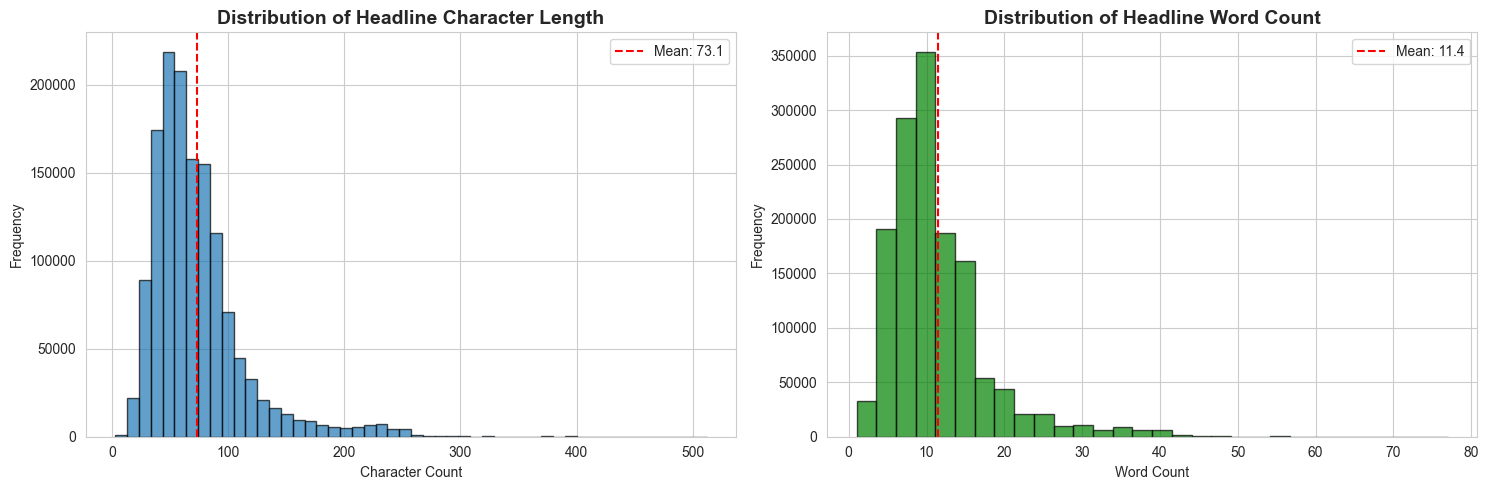

In [31]:
# Visualize headline length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(df['headline_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Headline Character Length', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['headline_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["headline_length"].mean():.1f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df['headline_word_count'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Headline Word Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['headline_word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["headline_word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()


### 3.2 Articles per Publisher


In [32]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

print("Articles per Publisher (Top 20):")
print("="*50)
print(publisher_counts.head(20))
print(f"\nTotal unique publishers: {df['publisher'].nunique()}")
print(f"Total articles: {len(df)}")


Articles per Publisher (Top 20):
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

Total unique publishers: 1034
Total articles: 1407328


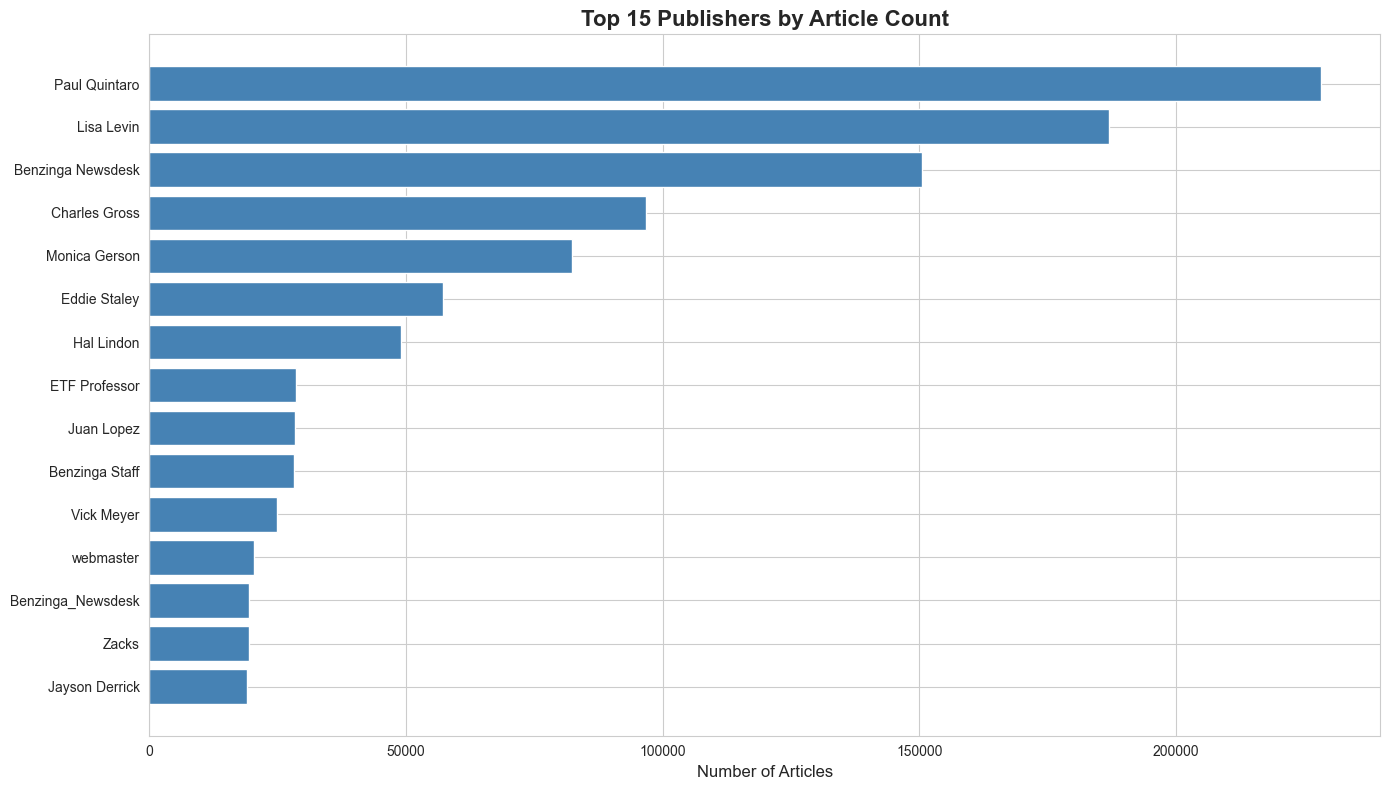

In [33]:
# Visualize top publishers
plt.figure(figsize=(14, 8))
top_publishers = publisher_counts.head(15)
plt.barh(range(len(top_publishers)), top_publishers.values, color='steelblue')
plt.yticks(range(len(top_publishers)), top_publishers.index)
plt.xlabel('Number of Articles', fontsize=12)
plt.title('Top 15 Publishers by Article Count', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 3.3 Publication Date Trends


In [34]:
# Articles by year
articles_by_year = df['year'].value_counts().sort_index()
print("Articles by Year:")
print("="*50)
print(articles_by_year)


Articles by Year:
year
2009     11489
2010     81319
2011    131322
2012    122649
2013    121529
2014    134859
2015    135295
2016    141892
2017    124456
2018    146924
2019    150380
2020    105214
Name: count, dtype: int64


In [35]:
# Articles by month
articles_by_month = df['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Articles by Month:")
print("="*50)
for month, count in articles_by_month.items():
    print(f"{month_names[month-1]}: {count}")


Articles by Month:
Jan: 121545
Feb: 122836
Mar: 121949
Apr: 121813
May: 130340
Jun: 106598
Jul: 110764
Aug: 124041
Sep: 96089
Oct: 124800
Nov: 121430
Dec: 105123


In [36]:
# Articles by day of week
articles_by_dow = df['day_of_week'].value_counts()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
articles_by_dow = articles_by_dow.reindex([d for d in dow_order if d in articles_by_dow.index])

print("Articles by Day of Week:")
print("="*50)
print(articles_by_dow)


Articles by Day of Week:
day_of_week
Monday       265139
Tuesday      296505
Wednesday    300922
Thursday     302619
Friday       217918
Saturday       7759
Sunday        16466
Name: count, dtype: int64


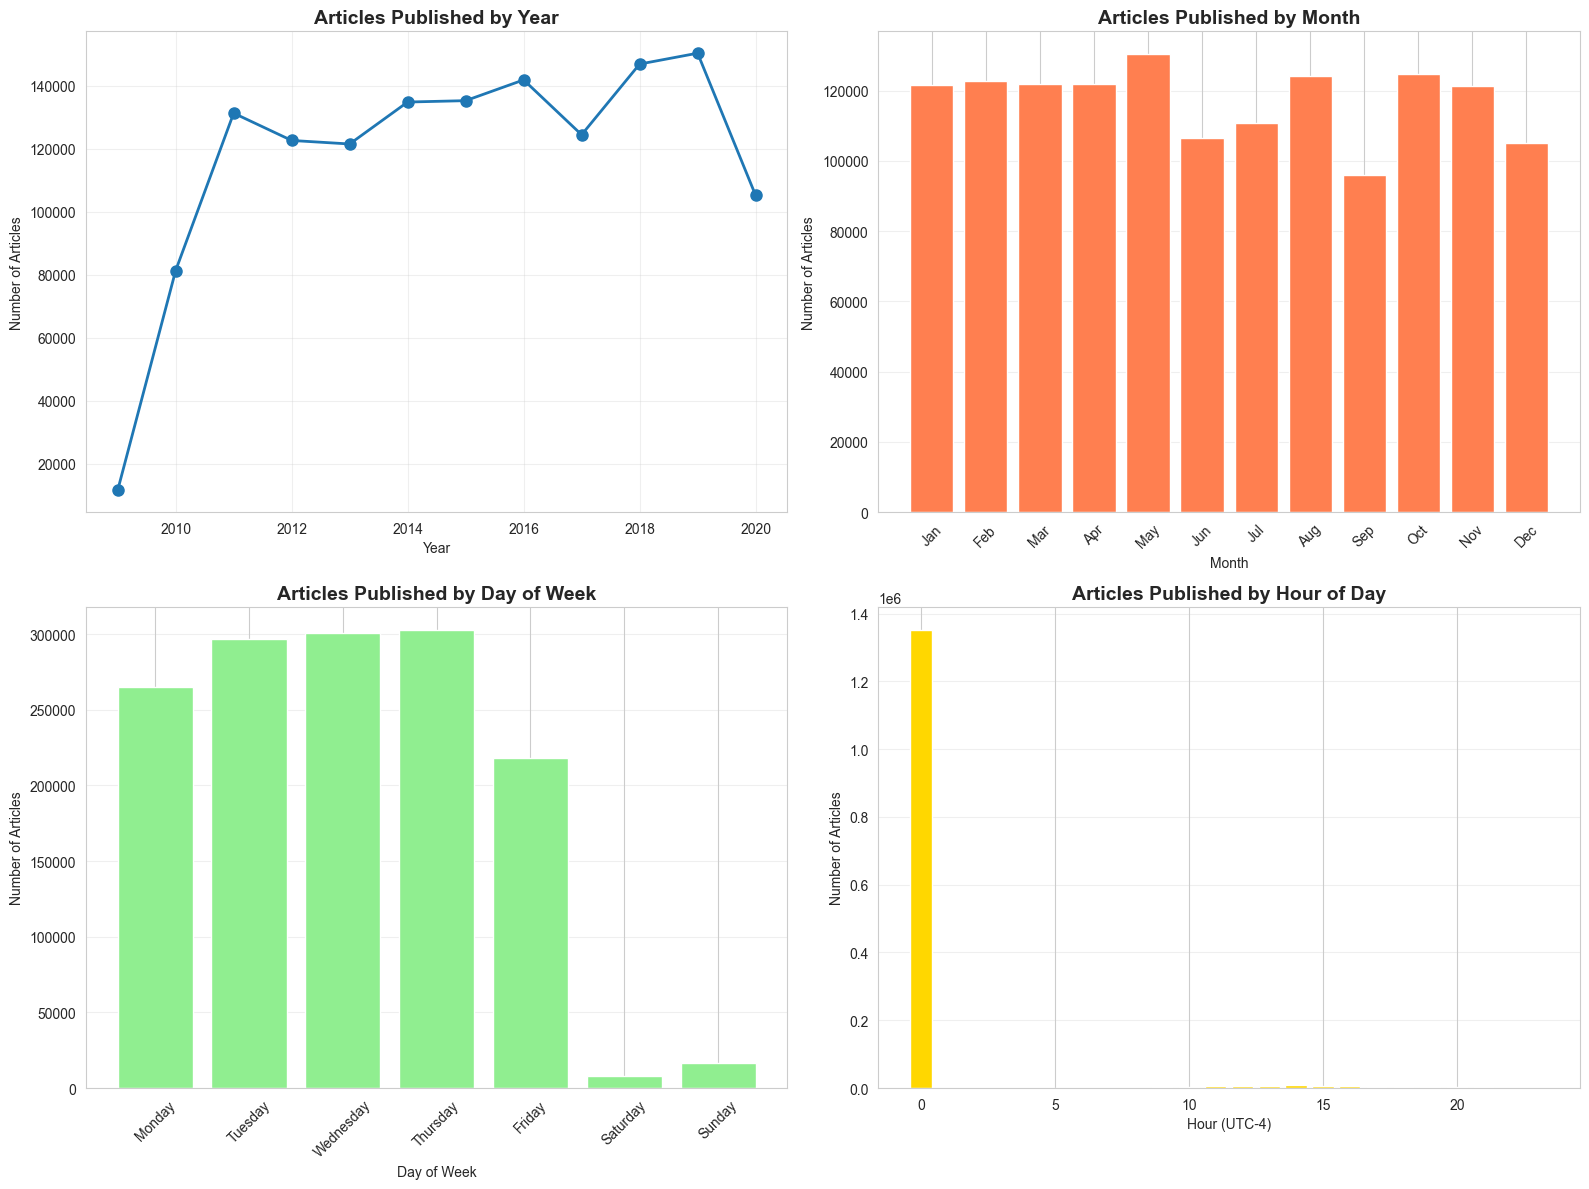

In [37]:
# Visualize temporal trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Articles by year
axes[0, 0].plot(articles_by_year.index, articles_by_year.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Articles Published by Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Articles')
axes[0, 0].grid(True, alpha=0.3)

# Articles by month
axes[0, 1].bar(articles_by_month.index, articles_by_month.values, color='coral')
axes[0, 1].set_title('Articles Published by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Articles by day of week
axes[1, 0].bar(range(len(articles_by_dow)), articles_by_dow.values, color='lightgreen')
axes[1, 0].set_title('Articles Published by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Articles')
axes[1, 0].set_xticks(range(len(articles_by_dow)))
axes[1, 0].set_xticklabels(articles_by_dow.index, rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Articles by hour
articles_by_hour = df['hour'].value_counts().sort_index()
axes[1, 1].bar(articles_by_hour.index, articles_by_hour.values, color='gold')
axes[1, 1].set_title('Articles Published by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour (UTC-4)')
axes[1, 1].set_ylabel('Number of Articles')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 4. Text Analysis and Topic Modeling

### 4.1 Common Keywords and Phrases


In [38]:
# Prepare text for analysis
stop_words = set(stopwords.words('english'))
# Add financial domain-specific stop words
financial_stopwords = {'stock', 'stocks', 'company', 'companies', 'market', 'markets', 
                      'price', 'prices', 'trading', 'trade', 'trades', 'day', 'week', 
                      'year', 'time', 'news', 'article', 'report', 'reports'}
stop_words.update(financial_stopwords)

def extract_keywords(text):
    """Extract keywords from text"""
    if pd.isna(text):
        return []
    tokens = word_tokenize(text.lower())
    # Filter out stopwords, punctuation, and short words
    keywords = [token for token in tokens 
                if token.isalpha() and len(token) > 2 and token not in stop_words]
    return keywords

# Extract keywords from all headlines
print("Extracting keywords from headlines...")
all_keywords = []
for headline in df['headline']:
    all_keywords.extend(extract_keywords(headline))

# Count keyword frequency
keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(30)

print("\nTop 30 Keywords:")
print("="*50)
for keyword, count in top_keywords:
    print(f"{keyword:20s}: {count:6d}")


Extracting keywords from headlines...

Top 30 Keywords:
eps                 : 128801
est                 : 122289
shares              : 114140
update              :  91645
earnings            :  87183
sales               :  79528
top                 :  78493
benzinga            :  74466
announces           :  66531
buy                 :  63928
downgrades          :  61942
raises              :  57793
upgrades            :  56802
target              :  54669
maintains           :  52960
higher              :  48150
new                 :  47875
session             :  45333
says                :  43123
moving              :  42248
sees                :  37971
estimate            :  37938
energy              :  35604
initiates           :  34981
neutral             :  34352
lower               :  34184
bank                :  34058
lowers              :  33855
scheduled           :  32835
coverage            :  32323


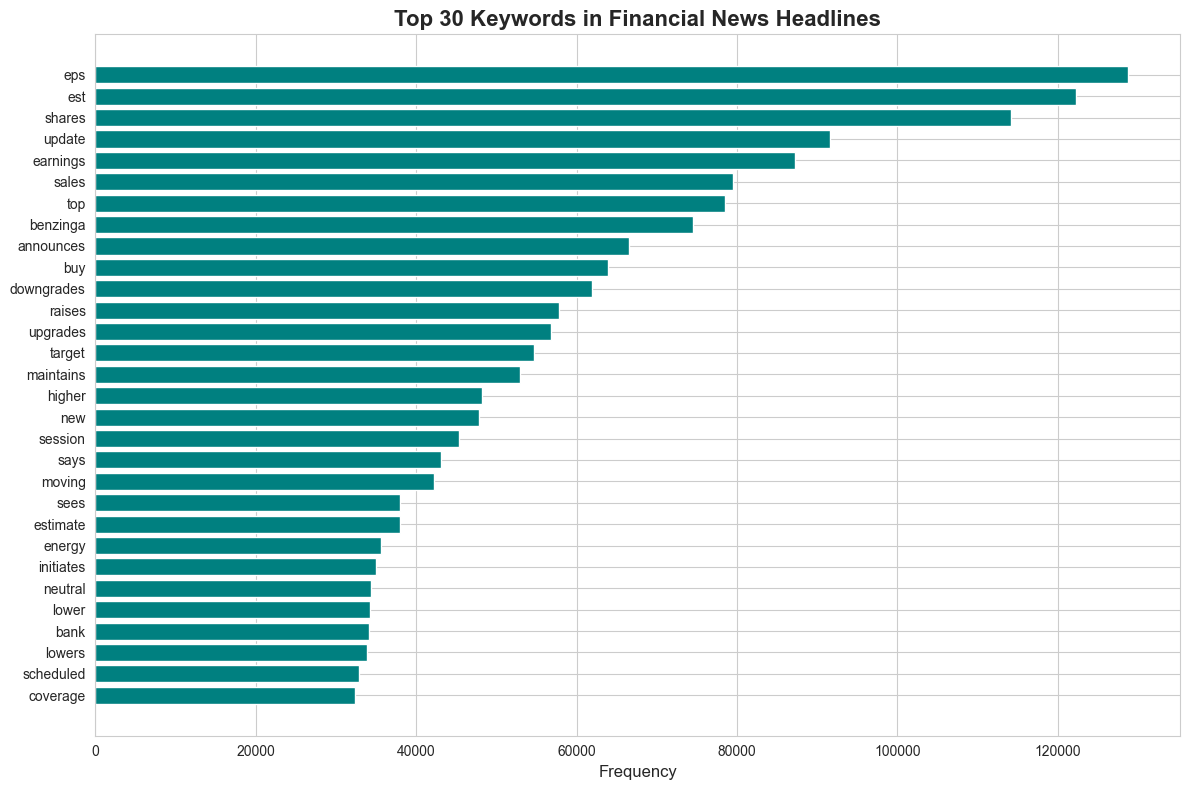

In [39]:
# Visualize top keywords
keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'Count'])

plt.figure(figsize=(12, 8))
plt.barh(range(len(keywords_df)), keywords_df['Count'].values, color='teal')
plt.yticks(range(len(keywords_df)), keywords_df['Keyword'].values)
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 30 Keywords in Financial News Headlines', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


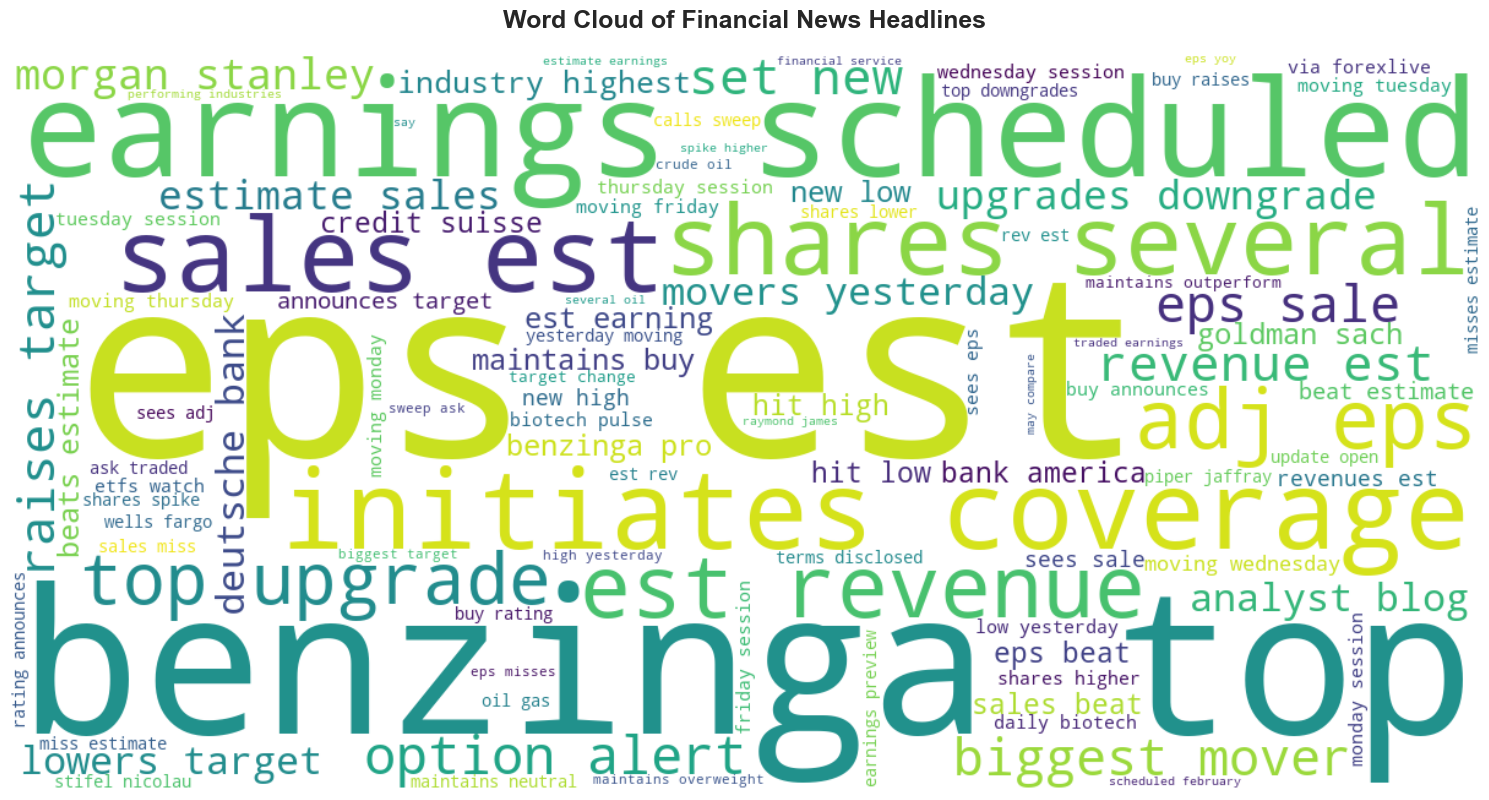

In [40]:
# Create word cloud
text_for_wordcloud = ' '.join(all_keywords)

wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                      max_words=100, colormap='viridis').generate(text_for_wordcloud)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Financial News Headlines', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 4.2 Extract Significant Events and Phrases


In [41]:
# Look for significant financial events/phrases
significant_phrases = [
    'fda approval', 'price target', 'earnings', 'revenue', 'profit', 
    'merger', 'acquisition', 'ipo', 'dividend', 'split', 'upgrade', 
    'downgrade', 'analyst', 'rating', 'forecast', 'guidance', 
    '52-week high', '52-week low', 'bullish', 'bearish'
]

phrase_counts = {}
for phrase in significant_phrases:
    count = df['headline'].str.lower().str.contains(phrase, na=False).sum()
    phrase_counts[phrase] = count

phrase_df = pd.DataFrame(list(phrase_counts.items()), columns=['Phrase', 'Count'])
phrase_df = phrase_df.sort_values('Count', ascending=False)

print("Significant Financial Phrases in Headlines:")
print("="*50)
print(phrase_df.to_string(index=False))


Significant Financial Phrases in Headlines:
      Phrase  Count
    earnings  86626
   downgrade  67062
     upgrade  62091
price target  47634
     revenue  39695
     analyst  25069
 52-week low  24896
52-week high  24874
      rating  24061
    dividend  21572
    guidance  15655
      profit  12195
 acquisition   8911
         ipo   8212
      merger   5621
    forecast   4163
     bullish   3677
       split   1759
fda approval   1546
     bearish   1272


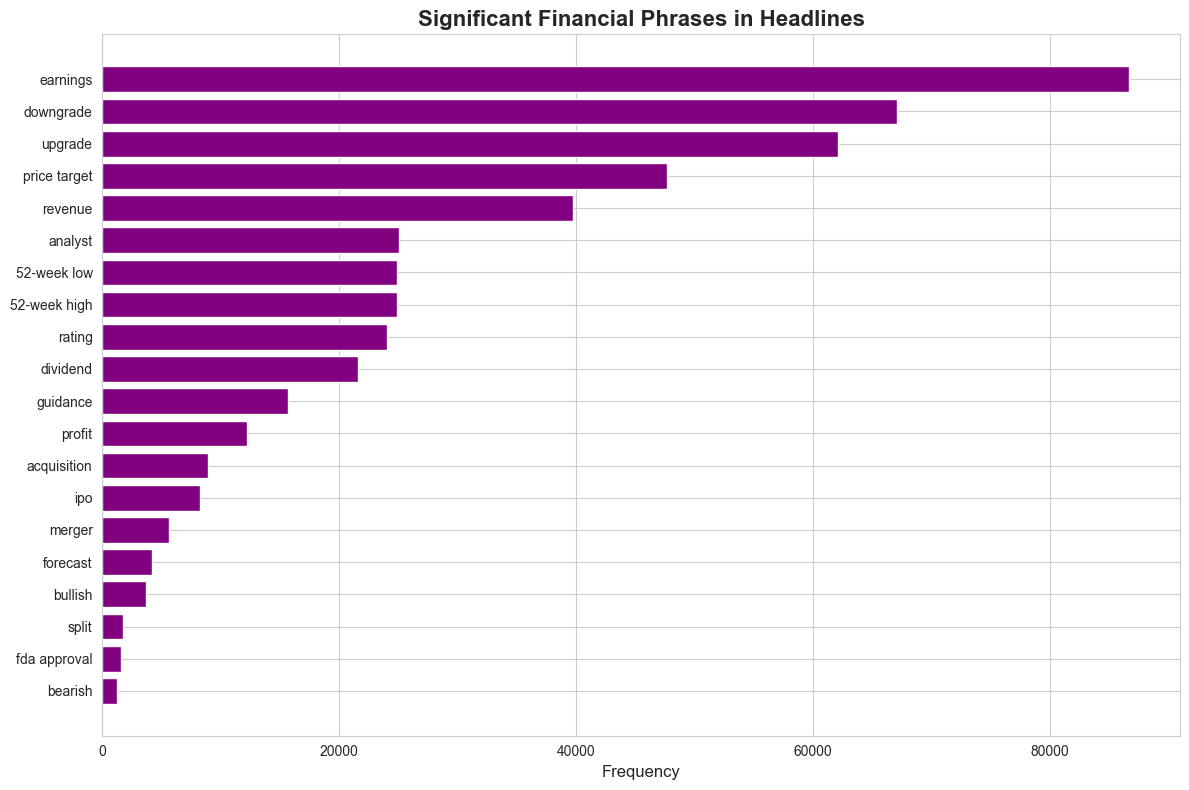

In [42]:
# Visualize significant phrases
plt.figure(figsize=(12, 8))
plt.barh(range(len(phrase_df)), phrase_df['Count'].values, color='purple')
plt.yticks(range(len(phrase_df)), phrase_df['Phrase'].values)
plt.xlabel('Frequency', fontsize=12)
plt.title('Significant Financial Phrases in Headlines', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 5. Time Series Analysis

### 5.1 Publication Frequency Over Time


In [43]:
# Create time series of daily publication frequency
daily_counts = df.groupby('date_only').size().reset_index(name='article_count')
daily_counts['date_only'] = pd.to_datetime(daily_counts['date_only'])
daily_counts = daily_counts.sort_values('date_only')

print(f"Date range: {daily_counts['date_only'].min()} to {daily_counts['date_only'].max()}")
print(f"Total days with articles: {len(daily_counts)}")
print(f"\nDaily publication statistics:")
print(daily_counts['article_count'].describe())


Date range: 2009-02-14 00:00:00 to 2020-06-11 00:00:00
Total days with articles: 3955

Daily publication statistics:
count    3955.000000
mean      355.835145
std       281.533761
min         1.000000
25%        33.000000
50%       407.000000
75%       551.000000
max      2739.000000
Name: article_count, dtype: float64


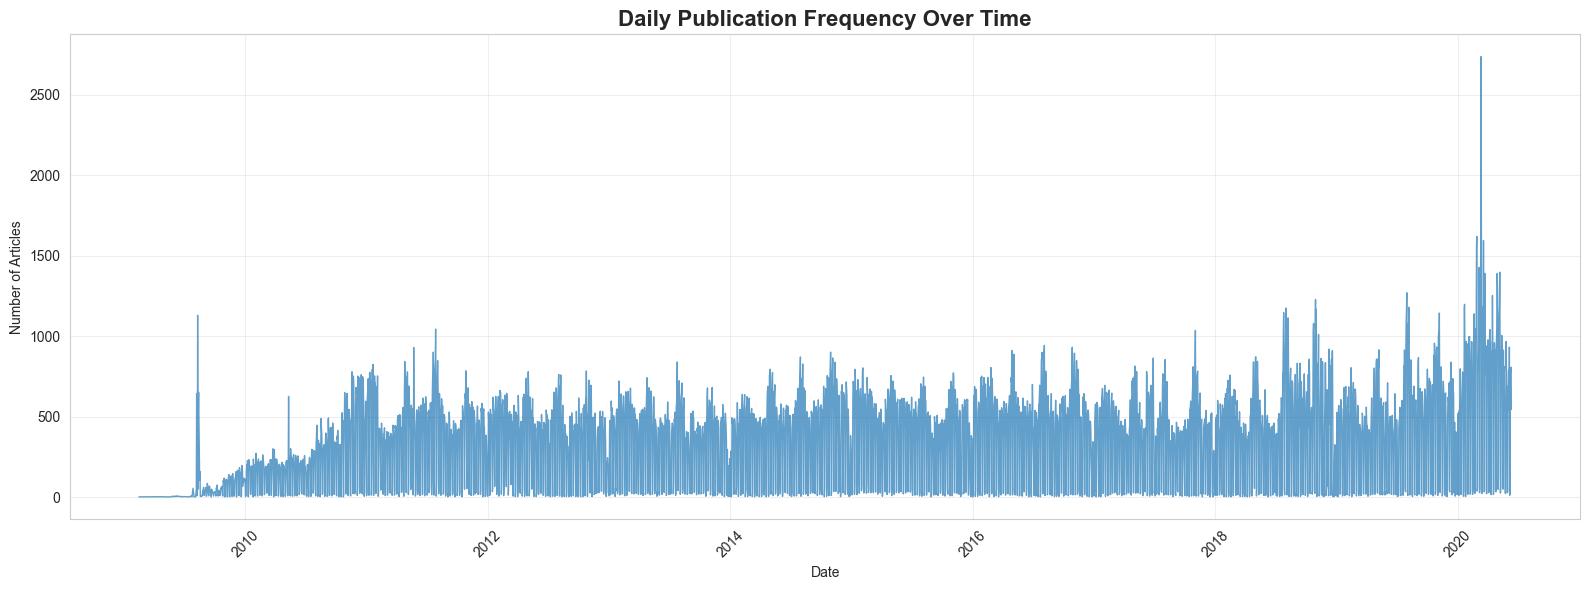

In [44]:
# Plot daily publication frequency
plt.figure(figsize=(16, 6))
plt.plot(daily_counts['date_only'], daily_counts['article_count'], linewidth=1, alpha=0.7)
plt.title('Daily Publication Frequency Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


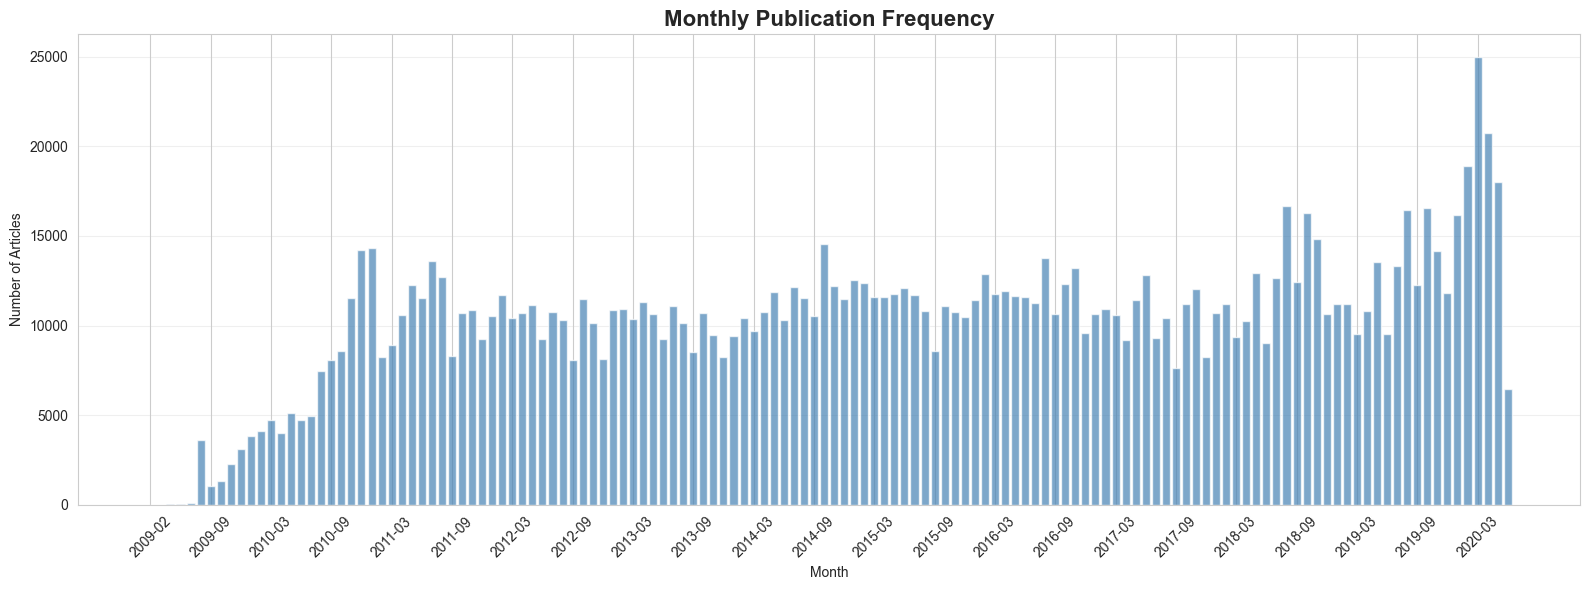

In [45]:
# Monthly aggregation for better visualization
df['year_month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size().reset_index(name='article_count')
monthly_counts['year_month'] = monthly_counts['year_month'].astype(str)

plt.figure(figsize=(16, 6))
plt.bar(range(len(monthly_counts)), monthly_counts['article_count'].values, 
        color='steelblue', alpha=0.7)
plt.title('Monthly Publication Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(range(0, len(monthly_counts), max(1, len(monthly_counts)//20)), 
           monthly_counts['year_month'][::max(1, len(monthly_counts)//20)], 
           rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### 5.2 Publishing Time Analysis


In [46]:
# Analyze publishing times
print("Publishing Time Analysis:")
print("="*50)
print(f"Most common publishing hour: {df['hour'].mode()[0]}:00")
print(f"\nArticles by hour (top 10):")
print(df['hour'].value_counts().head(10))


Publishing Time Analysis:
Most common publishing hour: 0:00

Articles by hour (top 10):
hour
0     1351472
14       7669
13       5965
16       5732
15       5701
12       5527
11       5033
20       3939
21       2800
17       2710
Name: count, dtype: int64


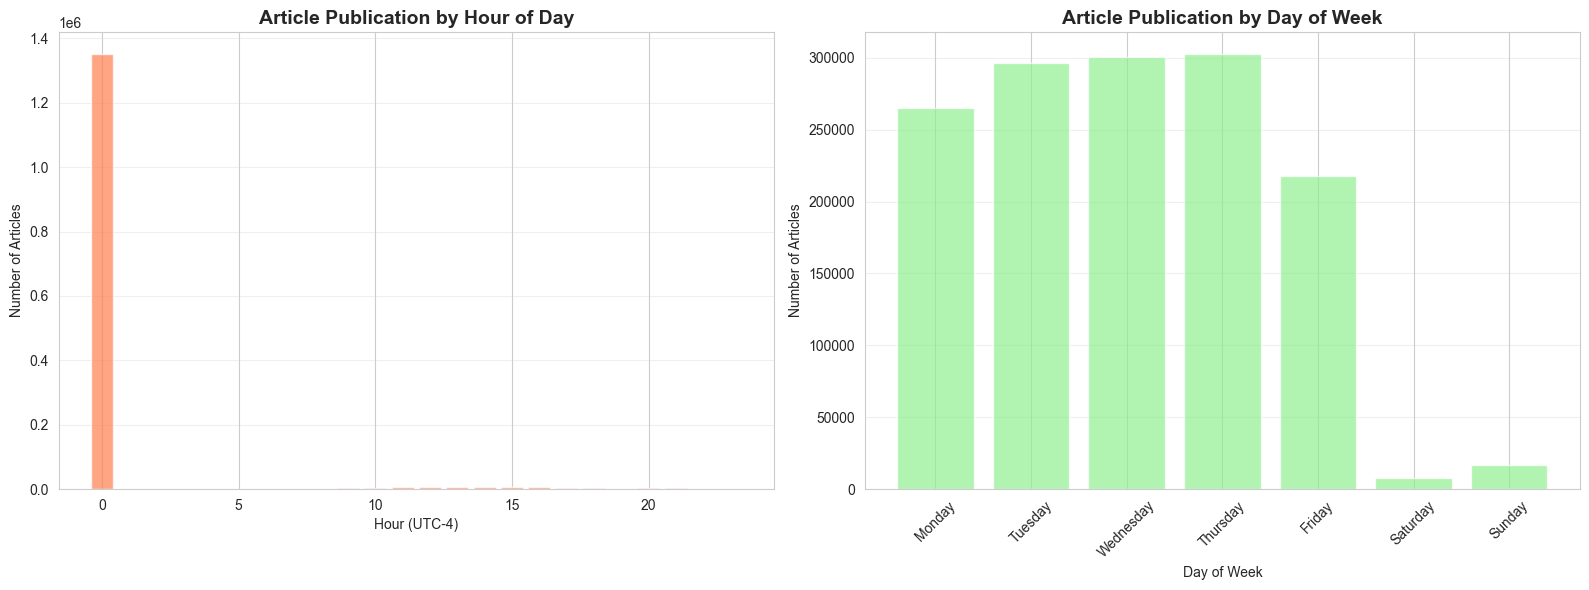

In [47]:
# Visualize publishing times
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hourly distribution
hour_counts = df['hour'].value_counts().sort_index()
axes[0].bar(hour_counts.index, hour_counts.values, color='coral', alpha=0.7)
axes[0].set_title('Article Publication by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour (UTC-4)')
axes[0].set_ylabel('Number of Articles')
axes[0].grid(True, alpha=0.3, axis='y')

# Day of week distribution
dow_counts = df['day_of_week'].value_counts()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = dow_counts.reindex([d for d in dow_order if d in dow_counts.index])
axes[1].bar(range(len(dow_counts)), dow_counts.values, color='lightgreen', alpha=0.7)
axes[1].set_title('Article Publication by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Articles')
axes[1].set_xticks(range(len(dow_counts)))
axes[1].set_xticklabels(dow_counts.index, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 6. Publisher Analysis

### 6.1 Publisher Contribution Analysis


In [48]:
# Detailed publisher statistics
publisher_stats = df.groupby('publisher').agg({
    'headline': 'count',
    'stock': 'nunique',
    'date': ['min', 'max']
}).reset_index()

publisher_stats.columns = ['publisher', 'article_count', 'unique_stocks', 'first_article', 'last_article']
publisher_stats = publisher_stats.sort_values('article_count', ascending=False)

print("Publisher Statistics (Top 20):")
print("="*70)
print(publisher_stats.head(20).to_string(index=False))


Publisher Statistics (Top 20):
        publisher  article_count  unique_stocks first_article        last_article
    Paul Quintaro         228373           4703    2011-05-17 2018-06-07 00:00:00
       Lisa Levin         186979           4640    2010-07-30 2020-06-11 16:19:17
Benzinga Newsdesk         150484           4049    2015-01-15 2020-06-11 21:11:20
    Charles Gross          96732           4181    2011-11-08 2020-06-11 15:08:26
    Monica Gerson          82380           4012    2009-09-22 2017-10-03 00:00:00
     Eddie Staley          57254           4466    2011-06-27 2018-08-08 00:00:00
       Hal Lindon          49047           4474    2013-05-14 2019-10-07 00:00:00
    ETF Professor          28489           1891    2009-10-22 2020-06-11 19:25:36
       Juan Lopez          28438           2883    2011-12-13 2014-07-30 00:00:00
   Benzinga Staff          28114           3233    2009-07-27 2020-04-02 00:00:00
       Vick Meyer          24826           2287    2017-11-17 2020-

In [49]:
# Publisher contribution percentage
total_articles = len(df)
publisher_stats['contribution_pct'] = (publisher_stats['article_count'] / total_articles * 100).round(2)

print("\nPublisher Contribution (Top 15):")
print("="*70)
top_15 = publisher_stats.head(15)[['publisher', 'article_count', 'contribution_pct']]
print(top_15.to_string(index=False))

print(f"\nTop 15 publishers account for {top_15['contribution_pct'].sum():.2f}% of all articles")



Publisher Contribution (Top 15):
        publisher  article_count  contribution_pct
    Paul Quintaro         228373             16.23
       Lisa Levin         186979             13.29
Benzinga Newsdesk         150484             10.69
    Charles Gross          96732              6.87
    Monica Gerson          82380              5.85
     Eddie Staley          57254              4.07
       Hal Lindon          49047              3.49
    ETF Professor          28489              2.02
       Juan Lopez          28438              2.02
   Benzinga Staff          28114              2.00
       Vick Meyer          24826              1.76
        webmaster          20313              1.44
Benzinga_Newsdesk          19410              1.38
            Zacks          19390              1.38
   Jayson Derrick          19050              1.35

Top 15 publishers account for 73.84% of all articles


### 6.2 Publisher Domain Analysis (if email addresses are used)


In [50]:
# Check if publishers contain email addresses
import re

def extract_domain(text):
    """Extract domain from email or text"""
    if pd.isna(text):
        return None
    # Check for email pattern
    email_pattern = r'[a-zA-Z0-9._%+-]+@([a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'
    match = re.search(email_pattern, str(text))
    if match:
        return match.group(1)
    return None

# Extract domains from publishers
df['publisher_domain'] = df['publisher'].apply(extract_domain)

if df['publisher_domain'].notna().sum() > 0:
    domain_counts = df['publisher_domain'].value_counts()
    print(f"Found {len(domain_counts)} unique domains from email addresses")
    print("\nTop domains:")
    print(domain_counts.head(10))
else:
    print("No email addresses found in publisher field.")
    print("\nAnalyzing publisher names as organizations instead...")
    
    # Analyze unique publisher names
    print(f"\nTotal unique publishers: {df['publisher'].nunique()}")
    print(f"\nPublisher name patterns (sample):")
    print(df['publisher'].value_counts().head(20))


Found 8 unique domains from email addresses

Top domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


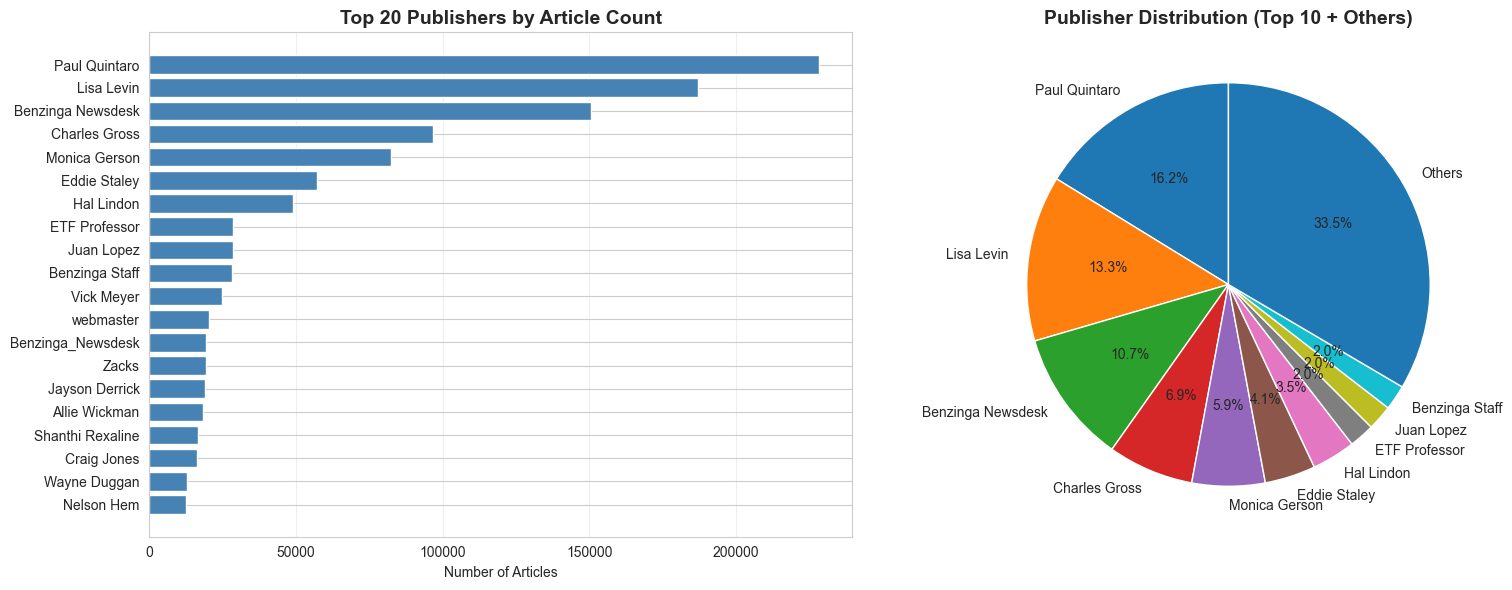

In [51]:
# Visualize publisher distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 publishers
top_20_publishers = publisher_counts.head(20)
axes[0].barh(range(len(top_20_publishers)), top_20_publishers.values, color='steelblue')
axes[0].set_yticks(range(len(top_20_publishers)))
axes[0].set_yticklabels(top_20_publishers.index)
axes[0].set_xlabel('Number of Articles')
axes[0].set_title('Top 20 Publishers by Article Count', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Publisher contribution pie chart (top 10)
top_10_publishers = publisher_counts.head(10)
others_count = publisher_counts.iloc[10:].sum()
pie_data = list(top_10_publishers.values) + [others_count]
pie_labels = list(top_10_publishers.index) + ['Others']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Publisher Distribution (Top 10 + Others)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 6.3 Stock Coverage by Publisher


In [52]:
# Analyze which publishers cover which stocks
publisher_stock = df.groupby(['publisher', 'stock']).size().reset_index(name='count')
publisher_stock_pivot = publisher_stock.pivot(index='publisher', columns='stock', values='count').fillna(0)

# Top publishers and their stock coverage
top_publishers_list = publisher_counts.head(10).index.tolist()
top_publishers_coverage = publisher_stock_pivot.loc[top_publishers_list]

print("Stock Coverage by Top Publishers:")
print("="*70)
print(top_publishers_coverage.to_string())


Stock Coverage by Top Publishers:
stock                  A     AA   AAC  AADR    AAL  AAMC  AAME   AAN   AAOI  AAON    AAP   AAPL  AAU  AAV  AAVL  AAWW  AAXJ    AB  ABAC  ABAX    ABB   ABBV    ABC  ABCB  ABCD  ABCO  ABCW  ABDC  ABEV   ABG  ABGB  ABIO   ABM  ABMD   ABR  ABTL    ABX   ABY   ACAD  ACAS  ACAT   ACC  ACCO  ACCU   ACE  ACET  ACFC  ACFN  ACG  ACGL   ACH  ACHC   ACHN  ACIW  ACLS   ACM  ACMP    ACN  ACNB   ACOR   ACP  ACPW  ACRE   ACRX  ACSF   ACST    ACT  ACTA   ACTG  ACTS   ACU  ACUR  ACWI  ACWV  ACWX  ACXM   ACY  ADAT   ADBE    ADC  ADEP  ADES  ADGE  ADHD    ADI   ADK    ADM  ADMA  ADMP  ADMS  ADNC    ADP  ADPT  ADRA  ADRD  ADRE  ADRU    ADS   ADSK   ADT  ADTN  ADVS   ADX   ADXS  ADZ    AE  AEB   AEC   AEE   AEG  AEGN  AEGR  AEHR  AEIS   AEL   AEM    AEO  AEPI   AER  AERI   AES    AET  AETI   AEY   AEZS    AF  AFA  AFAM  AFB  AFC  AFCB  AFFX   AFG   AFH   AFK   AFL  AFMD  AFOP  AFSI   AFT     AG  AGA  AGC   AGCO   AGD  AGEN  AGF   AGG  AGII  AGIO   AGM    AGN  AGNC  AGNCB  A

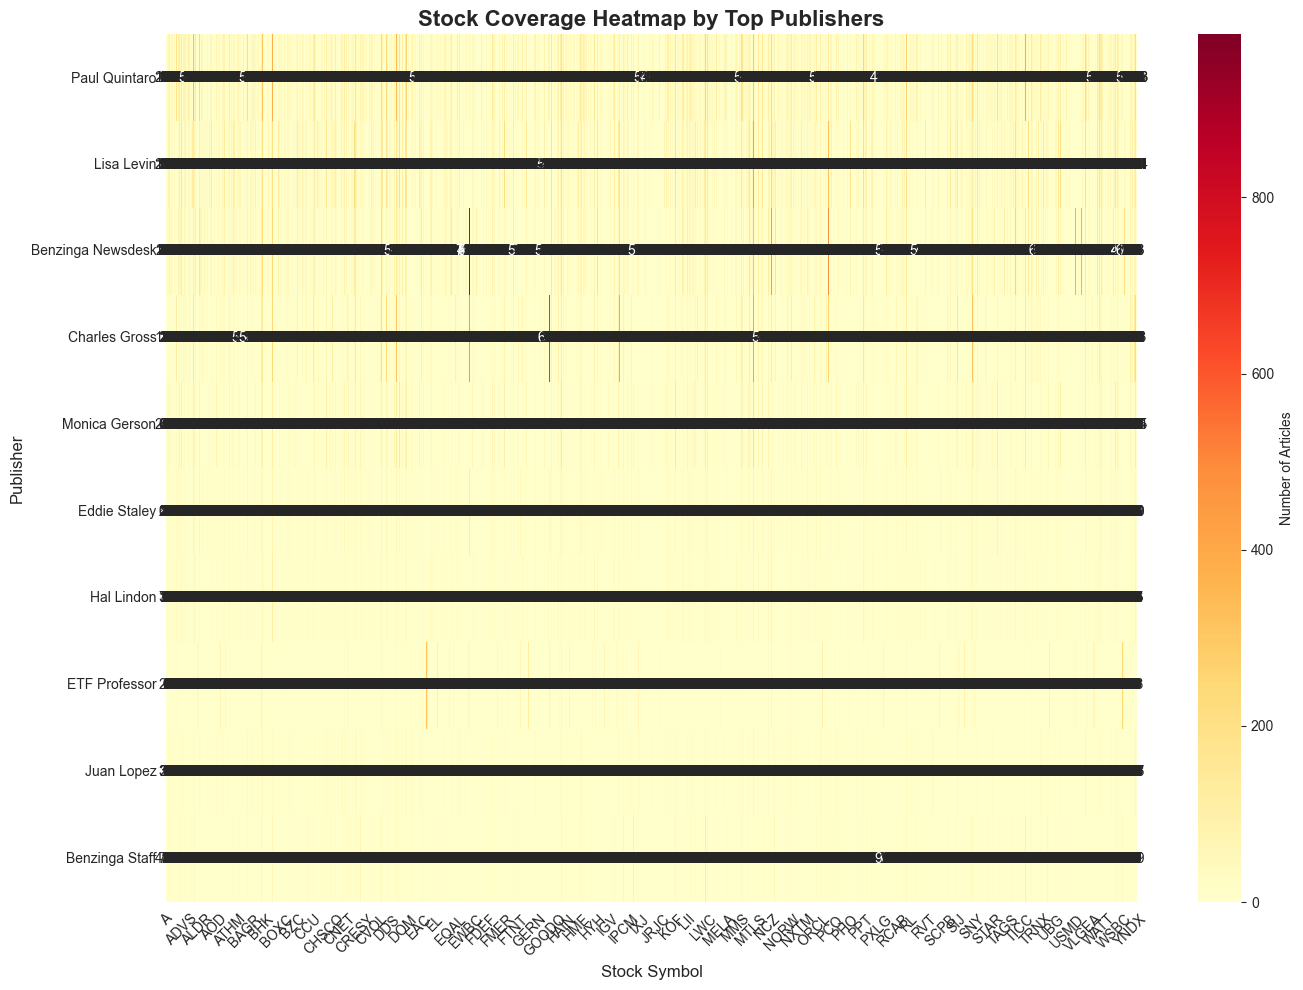

In [53]:
# Visualize stock coverage heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(top_publishers_coverage, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Articles'})
plt.title('Stock Coverage Heatmap by Top Publishers', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 7. Summary and Key Insights


In [54]:
print("="*70)
print("EDA SUMMARY - KEY INSIGHTS")
print("="*70)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total articles: {len(df):,}")
print(f"   - Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   - Unique publishers: {df['publisher'].nunique()}")
print(f"   - Unique stocks: {df['stock'].nunique()}")

print(f"\n2. HEADLINE STATISTICS:")
print(f"   - Average headline length: {df['headline_length'].mean():.1f} characters")
print(f"   - Average word count: {df['headline_word_count'].mean():.1f} words")

print(f"\n3. PUBLISHER INSIGHTS:")
print(f"   - Top publisher: {publisher_counts.index[0]} ({publisher_counts.iloc[0]:,} articles)")
print(f"   - Top 10 publishers account for {publisher_stats.head(10)['contribution_pct'].sum():.1f}% of articles")

print(f"\n4. TEMPORAL PATTERNS:")
print(f"   - Most active year: {articles_by_year.idxmax()} ({articles_by_year.max():,} articles)")
print(f"   - Most active month: {month_names[articles_by_month.idxmax()-1]} ({articles_by_month.max():,} articles)")
print(f"   - Most active day: {articles_by_dow.index[0]} ({articles_by_dow.iloc[0]:,} articles)")
print(f"   - Peak publishing hour: {df['hour'].mode()[0]}:00")

print(f"\n5. TEXT ANALYSIS:")
print(f"   - Top keyword: '{top_keywords[0][0]}' (appears {top_keywords[0][1]:,} times)")
print(f"   - Most common phrase: '{phrase_df.iloc[0]['Phrase']}' ({phrase_df.iloc[0]['Count']:,} occurrences)")

print("\n" + "="*70)


EDA SUMMARY - KEY INSIGHTS

1. DATASET OVERVIEW:
   - Total articles: 1,407,328
   - Date range: 2009-02-14 00:00:00 to 2020-06-11 21:12:35
   - Unique publishers: 1034
   - Unique stocks: 6204

2. HEADLINE STATISTICS:
   - Average headline length: 73.1 characters
   - Average word count: 11.4 words

3. PUBLISHER INSIGHTS:
   - Top publisher: Paul Quintaro (228,373 articles)
   - Top 10 publishers account for 66.5% of articles

4. TEMPORAL PATTERNS:
   - Most active year: 2019 (150,380 articles)
   - Most active month: May (130,340 articles)
   - Most active day: Monday (265,139 articles)
   - Peak publishing hour: 0:00

5. TEXT ANALYSIS:
   - Top keyword: 'eps' (appears 128,801 times)
   - Most common phrase: 'earnings' (86,626 occurrences)

